<a href="https://colab.research.google.com/github/ALejandroCh17/Tennis-Ball-Robot/blob/daniel_branch/rally_rover_tennis_ball_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tennis Ball Image Binary Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import os
import random
from hashlib import sha256
from PIL import Image
from tensorflow.keras.optimizers import RMSprop

## Exploratory Data Analysis

In [ ]:
# Define the paths to the folders containing the images
folders = [
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'
]

**Sample Image Display**

In [ ]:
# Gather all image paths from the folders
all_image_paths = []
for folder in folders:
    for image_name in os.listdir(folder):
        all_image_paths.append(os.path.join(folder, image_name))

In [ ]:
# Select 5 random images from the entire dataset
selected_image_paths = random.sample(all_image_paths, 5)

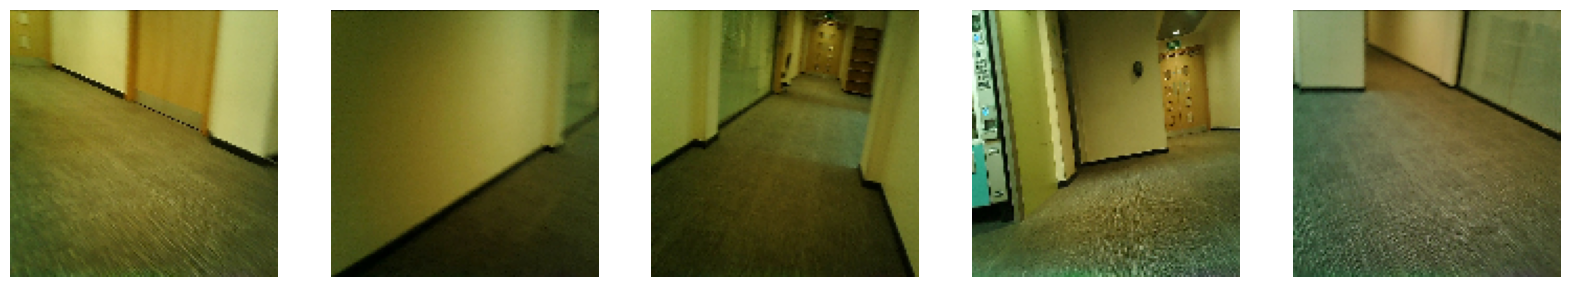

In [ ]:
# Plot the selected images
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(selected_image_paths):
    img = load_img(img_path, color_mode='rgb', target_size=(128, 128))  # Load and resize the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

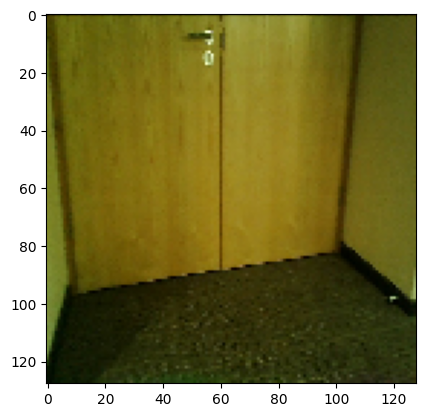

In [ ]:
# Showing no ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty/empty517.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

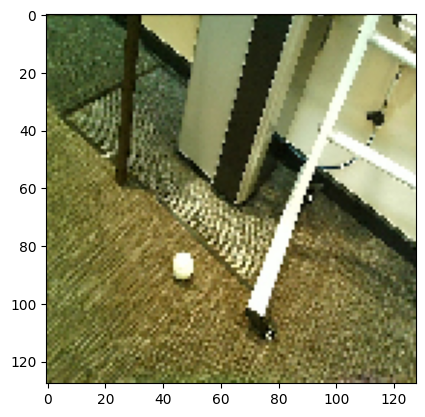

In [ ]:
# Showing ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls/ball97.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

A comparison between both image confirms our expectation of a ball either present or not present.

**Label Distribution**

In [ ]:
# Converts images to arrays for processing.
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder,filename), color_mode='rgb', target_size=(128, 128))
        img_arr = img_to_array(img)
        images.append(img_arr)
    return images

In [ ]:
x_train_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls')
x_train_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty')
x_test_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls')
x_test_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty')

In [ ]:
# Set the directory for each class
dir_train_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls'
dir_train_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty'
dir_test_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls'
dir_test_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'

In [ ]:
# Count the number of images in each directory
total_balls = len(os.listdir(dir_train_balls)) + len(os.listdir(dir_test_balls))
total_empty = len(os.listdir(dir_train_empty)) + len(os.listdir(dir_test_empty))

print(f'Balls: {total_balls}')
print(f'Empty: {total_empty}')

Balls: 446
Empty: 446


There are equal number of both types of images after modifying google drive file.

**Image Size**

In [ ]:
def check_image_sizes(directories):
    unique_sizes = set()

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                image_path = os.path.join(directory, filename)
                with Image.open(image_path) as img:
                    unique_sizes.add(img.size)  # img.size is a tuple (width, height)

    # If there's only one unique size in the set, all images are the same size
    return len(unique_sizes) == 1, unique_sizes

In [ ]:
# Use the function and print the result
all_same_size, unique_sizes = check_image_sizes(folders)
print(f"All images across all folders are the same size: {all_same_size}")
if not all_same_size:
    print(f"Unique image sizes found across all folders: {unique_sizes}")

All images across all folders are the same size: True


## Data Preprocessing

**Removing Duplicates**

In [ ]:
# Concatenating no-ball and yes-ball sets together
y_train = np.concatenate( ( np.ones(len(x_train_balls)), np.zeros(len(x_train_empty))) )
x_train = np.concatenate( (np.array(x_train_balls), np.array(x_train_empty) ) )
y_test = np.concatenate( (np.ones(len(x_test_balls)), np.zeros(len(x_test_empty))) )
x_test = np.concatenate( (np.array(x_test_balls), np.array(x_test_empty) ) )

In [ ]:
# Combine the datasets
x_combined = np.concatenate((x_train, x_test))
y_combined = np.concatenate((y_train, y_test))

In [ ]:
print(f'Total: {len(x_combined)}')

Total: 892


892 total images in dataset before removing duplicates

In [ ]:
# Flatten the image data
flattened_images = [image.flatten() for image in x_combined]

# Hash the flattened data
hashes = [sha256(image.data.tobytes()).hexdigest() for image in flattened_images]

# Identify and remove duplicates
unique_hashes = set()
unique_images = []

for i, hash_val in enumerate(hashes):
    if hash_val not in unique_hashes:
        unique_hashes.add(hash_val)
        unique_images.append(x_combined[i])

# unique_images now contains only unique images
x_combined = np.array(unique_images)

In [ ]:
print(f'Total: {len(x_combined)}')

Total: 892


892 images after. Data already had all unique images

## Data Split

In [ ]:
# Shuffle the combined dataset
randomize_combined = np.arange(len(y_combined))
np.random.shuffle(randomize_combined)
x_combined = x_combined[randomize_combined]
y_combined = y_combined[randomize_combined]

In [ ]:
# New Split
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_combined, y_combined, test_size=0.30, random_state=42)

# Normalize the pixel values if you haven't done it before
x_train_new = x_train_new / 255
x_test_new = x_test_new / 255

In [ ]:
# Display the shapes of the resulting datasets
print("X_train shape:", x_train_new.shape)
print("X_test shape:", x_test_new.shape)
print("y_train shape:", y_train_new.shape)
print("y_test shape:", y_test_new.shape)

X_train shape: (624, 128, 128, 3)
X_test shape: (268, 128, 128, 3)
y_train shape: (624,)
y_test shape: (268,)


In [ ]:
x_train_new[400:405]

array([[[[0.29803923, 0.3019608 , 0.03529412],
         [0.2901961 , 0.30980393, 0.04705882],
         [0.28235295, 0.2901961 , 0.04313726],
         ...,
         [0.1254902 , 0.11372549, 0.        ],
         [0.21960784, 0.1764706 , 0.        ],
         [0.13333334, 0.09019608, 0.        ]],

        [[0.5137255 , 0.5137255 , 0.16862746],
         [0.4862745 , 0.5137255 , 0.14117648],
         [0.4862745 , 0.5176471 , 0.12941177],
         ...,
         [0.27058825, 0.29803923, 0.08627451],
         [0.27058825, 0.26666668, 0.05490196],
         [0.2627451 , 0.25882354, 0.04705882]],

        [[0.53333336, 0.5372549 , 0.17254902],
         [0.5019608 , 0.52156866, 0.15294118],
         [0.48235294, 0.5019608 , 0.14117648],
         ...,
         [0.27450982, 0.27450982, 0.07058824],
         [0.28627452, 0.29411766, 0.10196079],
         [0.27058825, 0.2901961 , 0.07058824]],

        ...,

        [[0.08627451, 0.10980392, 0.        ],
         [0.09019608, 0.10588235, 0.00784314]

In [ ]:
y_train_new[400:405]

array([0., 1., 0., 1., 0.])

## Model Development

In [ ]:
kernelSize = 3
poolingSize = 2
dropoutRate = 0.5

In [ ]:
model = Sequential()

# Convolutional layer 1 (hidden)
model.add(Conv2D(16, kernel_size=kernelSize, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(dropoutRate))

# Convolutional layer 2 (hidden)
model.add(Conv2D(32, kernel_size=kernelSize, activation='relu'))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(dropoutRate))

# Convolutional layer 3 (hidden)
model.add(Conv2D(64, kernel_size=kernelSize, activation='relu'))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(dropoutRate))

# Convolutional layer 3 (hidden)
model.add(Conv2D(128, kernel_size=kernelSize, activation='relu'))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(dropoutRate))

# (hidden)
model.add(Flatten())

# Dense layer (hidden)
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(dropoutRate))

# Dense layer (hidden)
model.add(Dense(units=16, activation='relu'))

# Output Layer
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

## Training model

In [ ]:
model.fit(x=x_train_new, y=y_train_new, validation_data=(x_test_new, y_test_new), epochs=20)

Epoch 1/20
20/20 [==============================] - 0s 21ms/step - loss: 0.5420 - accuracy: 0.7532 - val_loss: 0.5975 - val_accuracy: 0.7015
Epoch 2/20
20/20 [==============================] - 0s 14ms/step - loss: 0.5468 - accuracy: 0.7212 - val_loss: 0.5832 - val_accuracy: 0.7090
Epoch 3/20
20/20 [==============================] - 0s 13ms/step - loss: 0.5163 - accuracy: 0.7756 - val_loss: 0.5993 - val_accuracy: 0.6940
Epoch 4/20
20/20 [==============================] - 0s 13ms/step - loss: 0.5254 - accuracy: 0.7532 - val_loss: 0.6108 - val_accuracy: 0.6791
Epoch 5/20
20/20 [==============================] - 0s 13ms/step - loss: 0.5294 - accuracy: 0.7596 - val_loss: 0.5712 - val_accuracy: 0.7164
Epoch 6/20
20/20 [==============================] - 0s 13ms/step - loss: 0.5158 - accuracy: 0.7548 - val_loss: 0.5701 - val_accuracy: 0.7090
Epoch 7/20
20/20 [==============================] - 0s 12ms/step - loss: 0.5207 - accuracy: 0.7740 - val_loss: 0.5513 - val_accuracy: 0.7388
Epoch 8/20
20

## History

In [ ]:
history = pd.DataFrame(model.history.history)
model_accuracy = history.drop(columns=['loss', 'accuracy'])

<Axes: >

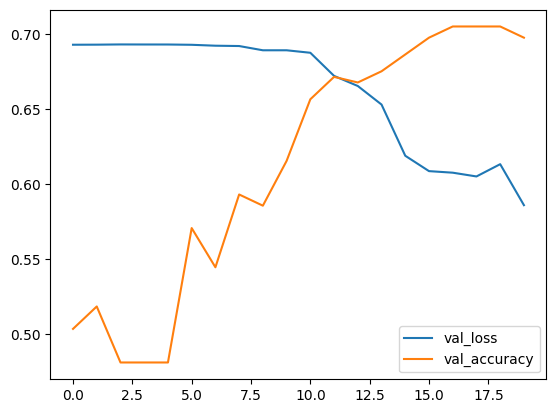

In [ ]:
model_accuracy.plot()

In [ ]:
predictions = np.rint(model.predict(x_test))

3/3 [==============================] - 0s 40ms/step


In [ ]:
print( classification_report(y_test, predictions) )

              precision    recall  f1-score   support

         0.0       0.83      0.69      0.75        29
         1.0       0.80      0.90      0.85        40

    accuracy                           0.81        69
   macro avg       0.82      0.79      0.80        69
weighted avg       0.81      0.81      0.81        69



In [ ]:
confusion_matrix(y_test, predictions)

array([[20,  9],
       [ 4, 36]])

In [ ]:
sample = 43
plt.imshow(x_test[sample], cmap=plt.cm.gray_r)
plt.title('prediction: ' + str(predictions[sample]) )

## Save model

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load model

In [ ]:
model = tf.keras.models.load_model('model.h5')